<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#RandomForest" data-toc-modified-id="RandomForest-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>RandomForest</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#Выбор-лучшей-модели" data-toc-modified-id="Выбор-лучшей-модели-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Выбор лучшей модели</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Предсказываем-количество-заказов-такси-на-тестовой-выборке" data-toc-modified-id="Предсказываем-количество-заказов-такси-на-тестовой-выборке-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Предсказываем количество заказов такси на тестовой выборке</a></span></li><li><span><a href="#Качество-прогноза" data-toc-modified-id="Качество-прогноза-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Качество прогноза</a></span><ul class="toc-item"><li><span><a href="#Прогноз-константой" data-toc-modified-id="Прогноз-константой-4.2.1"><span class="toc-item-num">4.2.1&nbsp;&nbsp;</span>Прогноз константой</a></span></li><li><span><a href="#Прогноз-предыдущим-значением-ряда" data-toc-modified-id="Прогноз-предыдущим-значением-ряда-4.2.2"><span class="toc-item-num">4.2.2&nbsp;&nbsp;</span>Прогноз предыдущим значением ряда</a></span></li></ul></li></ul></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

**Цель проекта:**
- Построить модель для предсказания пиковой нагрузки по заказам такси.

**Цели:**
- Загрузить данные, изучить их и провести ресемплирование.
- Обучить модели с перебором гиперпараметров, предварительно выделив тестовую выборку.
- Оценить лучшую модель на тестовой выборке.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from tqdm import tqdm
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit

## Подготовка

In [2]:
try:
    df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])
except:
    df = pd.read_csv('taxi.csv', parse_dates=[0], index_col=[0])

In [3]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [7]:
df.index.is_monotonic

True

**Вывод:** Загужены данные количества заказов с течением времени. Столбец с датами преобразован в datetime64 и сделан индексами всего датафрейма. Индексы расположены в хронологическом порядке. Произведено ресемплирование по одному часу.

## Анализ

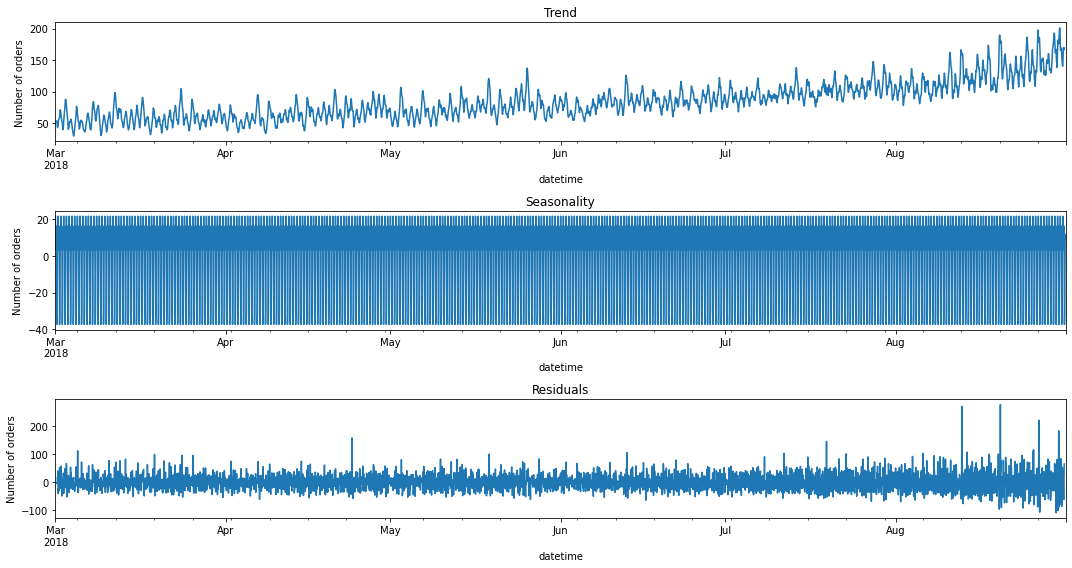

In [8]:
decomposed = seasonal_decompose(df, model='additive', period=12)

plt.figure(figsize=(15, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.ylabel('Number of orders')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.ylabel('Number of orders')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.ylabel('Number of orders')
plt.tight_layout()

Поскольку временной интервал слишком большой, предлагается подробнее рассмотреть 1 месяц

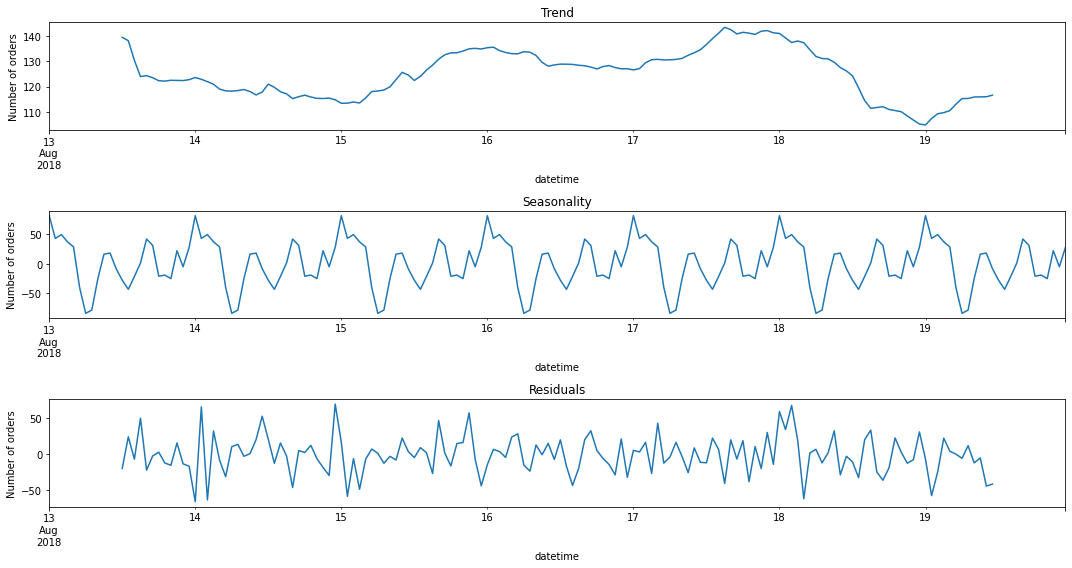

In [9]:
# рассмотрим графики на недельном интервале
df_week = df['2018-08-13':'2018-08-19']

decomposed = seasonal_decompose(df_week)
plt.figure(figsize=(15, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.ylabel('Number of orders')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.ylabel('Number of orders')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.ylabel('Number of orders')
plt.tight_layout()

In [10]:
# рассмотрим графики при сглаживании временных рядов
df_rolling = df.rolling(24, closed='left').mean()

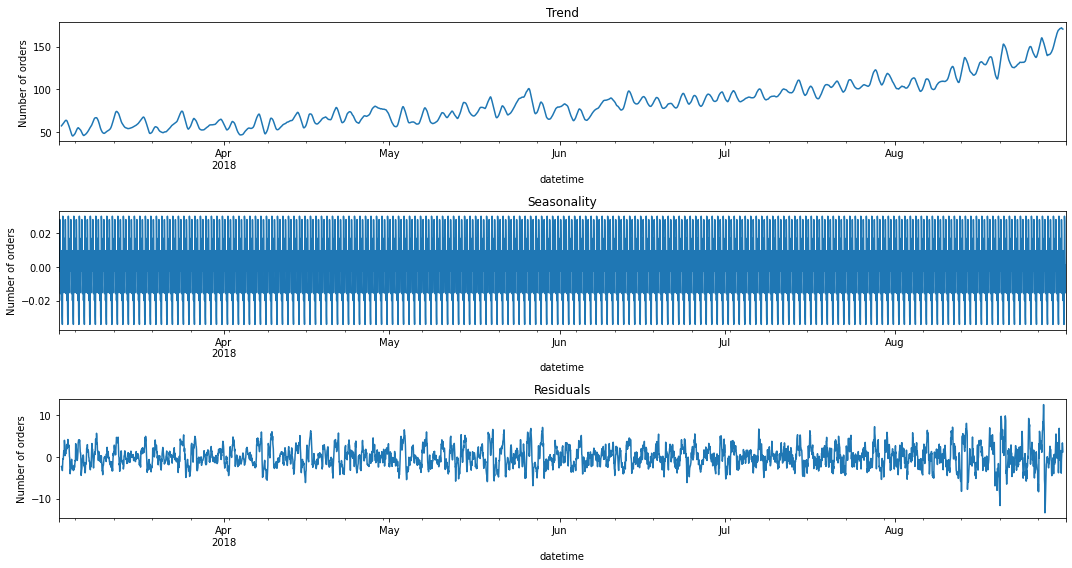

In [11]:
df_rolling.dropna(inplace=True)

decomposed = seasonal_decompose(df_rolling)

plt.figure(figsize=(15, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.ylabel('Number of orders')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.ylabel('Number of orders')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.ylabel('Number of orders')
plt.tight_layout()

Text(0.5, 1.0, 'Сhange in the mean value and standard deviation')

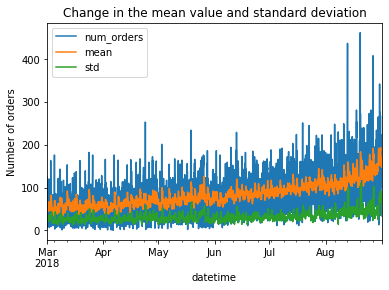

In [12]:
# рассмотрим как изменяется среднее значение и стандартное отклонение
df_analysis = df.copy()
df_analysis['mean'] = df_analysis['num_orders'].rolling(15, closed='left').mean()
df_analysis['std'] = df_analysis['num_orders'].rolling(15, closed='left').std()
df_analysis.plot()
plt.ylabel('Number of orders')
plt.title('Сhange in the mean value and standard deviation');

Text(0.5, 1.0, 'Difference of time series')

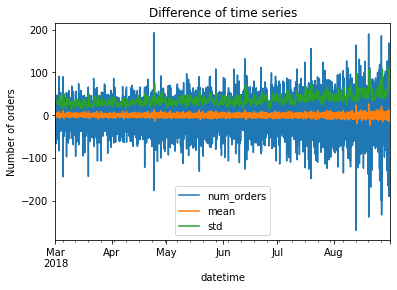

In [13]:
# вычислим разности временного ряда и рассмотрим изменение среднего значения и стандартного отклонения
df_dif = df.copy()
df_dif -= df_dif.shift()
df_dif['mean'] = df_dif['num_orders'].rolling(15, closed='left').mean()
df_dif['std'] = df_dif['num_orders'].rolling(15, closed='left').std()
df_dif.plot() 
plt.ylabel('Number of orders')
plt.title('Difference of time series');

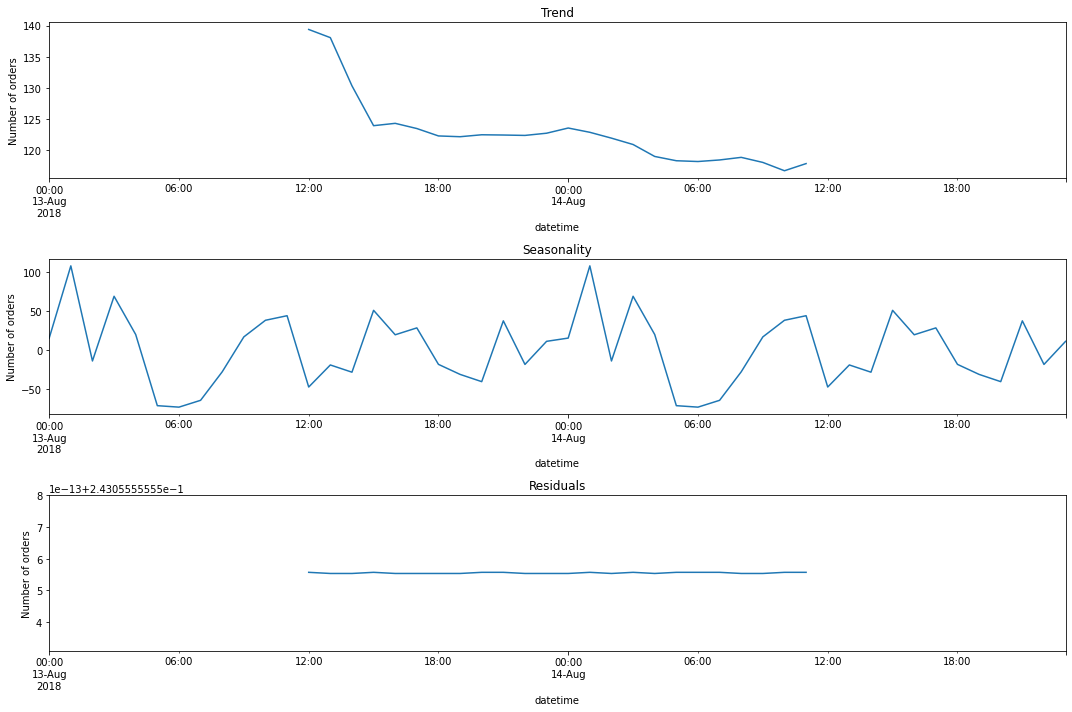

In [14]:
# рассмотрим графики на 2-дневном интервале
df_couple = df['2018-08-13':'2018-08-14']

decomposed = seasonal_decompose(df_couple)
plt.figure(figsize=(15, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.ylabel('Number of orders')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.ylabel('Number of orders')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.ylabel('Number of orders')
plt.tight_layout()

In [15]:
# Проведем тест Дики-Фуллера. H0: процесс нестационарный, H1: процесс стационарный
adf_test = adfuller(df)

print('p-value:', adf_test[1])

p-value: 0.028940051402612906


**Вывод:** В ходе анализа временного ряда выяснено, что ряд нестационарный, т.к. изменяются среднее и стандартное отклонение. Вдобавок, проведен тест Дики-Фуллера, который при статистической значимости 1%, не позволяет отвергнуть нулевую гипотезу о нестационарнсоти временного ряда. Однако, при статистической значимости в 5%, отвергаем нулевую гипотезу и считаем ряд стационарным. В итоге, получаем достаточно предсказуемый временной ряд.
<br>
В ряду присутствуют определенные паттерны, что указывает на наличе сезонных закономерностей. Тренд показывает увеличение количества заказов с весны по лето. При сглаживании временного ряда, тренд и сезонность остаюстя прежними.
<br> 
При рассмотрении 2-дневного интервала выделена суточная сезонность, где пики наблюдаются в районе 01:00, 03:00, 10-11:00, 15:00, 22:00, а спады наблюдаются в периоды с 05-07:00, с 12-14:00 и с 19-21:00. Скорее всего природа сезонности обусловлена расписанием прилетающих рейсов, в связи с чем резко увеличивается количество заказов такси из аэропорта.

## Обучение

In [16]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [17]:
def make_features(df, max_lag, rolling_mean_size):
    df_foo = df.copy()
    df_foo['day'] = df_foo.index.day
    df_foo['dayofweek'] = df_foo.index.dayofweek
    df_foo['hour'] = df_foo.index.hour

    for lag in range(1, max_lag + 1):
        df_foo['lag_{}'.format(lag)] = df_foo['num_orders'].shift(lag)

    df_foo['rolling_mean'] = df_foo['num_orders'].shift().rolling(rolling_mean_size, closed='left').mean()

    
    return df_foo.dropna()

In [18]:
df_new = make_features(df, 24, 12)

In [19]:
df_new.head(30)

,num_orders,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,2,4,0,58.0,113.0,66.0,61.0,45.0,73.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,59.750000
2018-03-02 01:00:00,120,2,4,1,90.0,58.0,113.0,66.0,61.0,45.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,56.583333
2018-03-02 02:00:00,75,2,4,2,120.0,90.0,58.0,113.0,66.0,61.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,61.583333
2018-03-02 03:00:00,64,2,4,3,75.0,120.0,90.0,58.0,113.0,66.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,68.916667
2018-03-02 04:00:00,20,2,4,4,64.0,75.0,120.0,90.0,58.0,113.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,71.166667
2018-03-02 05:00:00,11,2,4,5,20.0,64.0,75.0,120.0,90.0,58.0,...,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,71.000000
2018-03-02 06:00:00,11,2,4,6,11.0,20.0,64.0,75.0,120.0,90.0,...,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,69.083333
2018-03-02 07:00:00,7,2,4,7,11.0,11.0,20.0,64.0,75.0,120.0,...,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,66.333333
2018-03-02 08:00:00,46,2,4,8,7.0,11.0,11.0,20.0,64.0,75.0,...,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,61.166667


In [20]:
# разобьем данные на обучающую и тестовую выборки
train, test = train_test_split(df_new, random_state=12345, test_size=0.1, shuffle=False)
train = train.dropna()

In [21]:
# разобьем выборки на целевой признак и признаки
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

### LinearRegression

In [22]:
model_lr = LinearRegression()

tss = TimeSeriesSplit(n_splits=5)
scores_lr = cross_val_score(model_lr, features_train, target_train, cv=tss, scoring='neg_mean_squared_error')
rmse_lr = np.sqrt(-scores_lr)
rmse_lr = rmse_lr.mean()

### RandomForest

In [23]:
params_grid = {
    'n_estimators' : [10, 30, 60, 100],
    'max_depth' : [2, 5, 10, 15]
}

In [24]:
model_rf = RandomForestRegressor(random_state=12345)
GS_rf = GridSearchCV(estimator = model_rf,
                     param_grid = params_grid,
                     scoring = 'neg_root_mean_squared_error',
                     cv=tss, verbose=2)   

In [25]:
GS_rf.fit(features_train, target_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .......................max_depth=2, n_estimators=10; total time=   0.0s
[CV] END .......................max_depth=2, n_estimators=10; total time=   0.0s
[CV] END .......................max_depth=2, n_estimators=10; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=10; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=10; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=30; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=30; total time=   0.1s
[CV] END .......................max_depth=2, n_estimators=30; total time=   0.2s
[CV] END .......................max_depth=2, n_estimators=30; total time=   0.2s
[CV] END .......................max_depth=2, n_estimators=30; total time=   0.2s
[CV] END .......................max_depth=2, n_estimators=60; total time=   0.1s
[CV] END .......................max_depth=2, n_e

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(random_state=12345),
             param_grid={'max_depth': [2, 5, 10, 15],
                         'n_estimators': [10, 30, 60, 100]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [26]:
GS_rf.best_params_

{'max_depth': 15, 'n_estimators': 100}

In [27]:
rmse_rf = -GS_rf.best_score_
rmse_rf

25.159629098529688

### LightGBM

In [28]:
params_grid_lgb = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 150, 200]
}

In [29]:
model_lgb = lgb.LGBMRegressor(random_state=12345)

In [30]:
GS_lgb = GridSearchCV(estimator = model_lgb,
                     param_grid = params_grid_lgb,
                     scoring = 'neg_root_mean_squared_error',
                     cv=tss, verbose=-1)   

In [31]:
GS_lgb.fit(features_train, target_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMRegressor(random_state=12345),
             param_grid={'learning_rate': [0.05, 0.1],
                         'n_estimators': [100, 150, 200],
                         'num_leaves': [31, 50, 100]},
             scoring='neg_root_mean_squared_error', verbose=-1)

In [32]:
GS_lgb.best_params_

{'learning_rate': 0.05, 'n_estimators': 100, 'num_leaves': 100}

In [33]:
rmse_lgb = -GS_lgb.best_score_
rmse_lgb

24.90541326707042

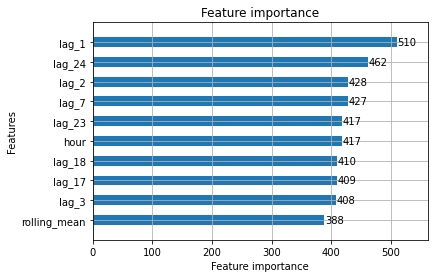

In [34]:
lgb.plot_importance(GS_lgb.best_estimator_, max_num_features=10, height=.5);

### CatBoost

In [35]:
model_cat = CatBoostRegressor(random_state=12345)

In [36]:
params_grid_cat = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8, 10],
    'iterations': [100, 150, 200]
}

In [37]:
GS_cat = GridSearchCV(
    estimator=model_cat, 
    param_grid=params_grid_cat, 
    cv=tss, 
    scoring='neg_root_mean_squared_error', 
    verbose=2
)

In [38]:
GS_cat.fit(features_train, target_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
0:	learn: 29.5221168	total: 48.1ms	remaining: 4.76s
1:	learn: 29.3997592	total: 49.6ms	remaining: 2.43s
2:	learn: 29.2802722	total: 51.1ms	remaining: 1.65s
3:	learn: 29.1346261	total: 52.6ms	remaining: 1.26s
4:	learn: 29.0124831	total: 54.1ms	remaining: 1.03s
5:	learn: 28.8787837	total: 55.4ms	remaining: 869ms
6:	learn: 28.7497869	total: 56.8ms	remaining: 755ms
7:	learn: 28.6181175	total: 58.2ms	remaining: 670ms
8:	learn: 28.4988010	total: 59.7ms	remaining: 604ms
9:	learn: 28.3715795	total: 61.2ms	remaining: 550ms
10:	learn: 28.2565222	total: 62.6ms	remaining: 507ms
11:	learn: 28.1381159	total: 64.1ms	remaining: 470ms
12:	learn: 28.0300165	total: 65.5ms	remaining: 438ms
13:	learn: 27.9239457	total: 67ms	remaining: 412ms
14:	learn: 27.8157664	total: 68.5ms	remaining: 388ms
15:	learn: 27.7052915	total: 70.1ms	remaining: 368ms
16:	learn: 27.5927112	total: 71.7ms	remaining: 350ms
17:	learn: 27.4787719	total: 73.2ms	remaining: 33

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7fcd7505ba30>,
             param_grid={'depth': [4, 6, 8, 10], 'iterations': [100, 150, 200],
                         'learning_rate': [0.01, 0.05, 0.1]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [39]:
GS_cat.best_params_

{'depth': 6, 'iterations': 200, 'learning_rate': 0.1}

In [40]:
rmse_cat = -GS_cat.best_score_
rmse_cat

24.405060881522168

### Выбор лучшей модели

In [41]:
models_info = [['LinearRegression', rmse_lr],
            ['RandomForestRegression', rmse_rf],
            ['LightGBM', rmse_lgb],
            ['CatBoost', rmse_cat]]

In [42]:
pd.DataFrame(models_info, columns=["Model","RMSE"])

,Model,RMSE
0,LinearRegression,27.152330
1,RandomForestRegression,25.159629
2,LightGBM,24.905413
3,CatBoost,24.405061


**Вывод:** Обучили 4 разные модели, из которых наилучшее значение метрики rmse показала модель CatBoost. Тестирование будет проводиться на ней.

## Тестирование

### Предсказываем количество заказов такси на тестовой выборке

In [43]:
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

In [44]:
predictions_test = GS_cat.predict(features_test)

In [45]:
rmse_test_cat = mean_squared_error(target_test, predictions_test)**0.5
rmse_test_cat

41.35309418000374

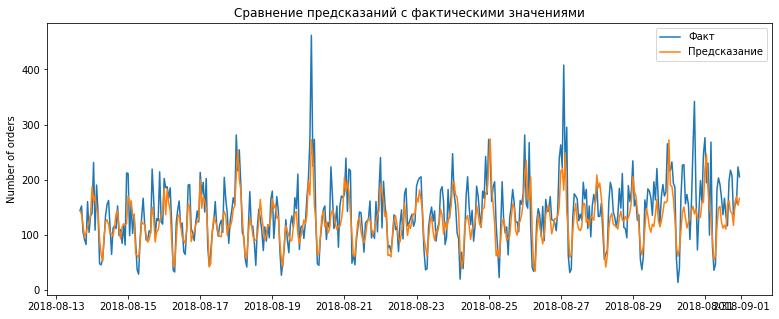

In [46]:
plt.figure(figsize=(13, 5))

plt.plot(target_test, label='Факт')
plt.plot(target_test.index, predictions_test, label='Предсказание')
plt.ylabel('Number of orders')
plt.title('Сравнение предсказаний с фактическими значениями')
plt.legend()
plt.show()

### Качество прогноза

#### Прогноз константой

In [47]:
pred_median = pd.Series(target_train.median(), index=target_test.index)
rmse_mean = mean_squared_error(target_test, pred_median) **0.5
rmse_mean

87.21093811714634

#### Прогноз предыдущим значением ряда

In [48]:
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]
rmse_mean = mean_squared_error(target_test, pred_previous) **0.5
rmse_mean

58.881776776551476

**Вывод:** Значение метрики RMSE на тестовой выборке оказалось меньше 48 и составило 41.3. Построенная модель в ходе проекта показывает лучший результат метрики RMSE, чем константный прогноз и прогноз предыдущим значением ряда.

## Общий вывод

В ходе работы на проектом выполнены следующие мероприятия:
- Загружены и проанализированы данные по заказам такси, произведено ресемплирование по 1 часу.
- Подготовлены выборки для обучения и тестирования моделей.
- Обучены 4 разные модели (LinearRegression, RandomForest, LightGBM и CatBoost), подобраны оптимальные гиперпараметры. 
- Выбрана наилучшая модель по точности предсказания временного ряда. Ей оказалась модель CatBoost.
- При проверке качества модели на тестовой выборке метрика RMSE составила 41.3, что входит в пределы порогового значения 48. Построенная модель в ходе проекта показывает лучший результат метрики RMSE, чем константный прогноз и прогноз предыдущим значением ряда.